In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.distributions.empirical_distribution import ECDF 
import xarray as xr
import matplotlib.pyplot as plt

import time

from renewable_data_load import *

from threshold_tools import *


import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Configure dask for parallel execution
import dask
dask.config.set(scheduler='threads', num_workers=10)  # Adjust num_workers to your CPU cores

In [28]:
resource = "windpower"
module = "onshore"
domain = "d02"
variable = "cf"
frequency = "day"

reference_gwl = 0.8
future_gwl = 2.0
window_size = 60


In [29]:
simulations = ['ec-earth3', "mpi-esm1-2-hr", "miroc6", "taiesm1"]
gwls = [reference_gwl, future_gwl]

# Load all datasets and organize by simulation and GWL
all_datasets = []

for sim in simulations:
    for gwl in gwls:
        gwl_label = 'ref' if gwl == reference_gwl else 'fut'
        filename = f"../data/drought_events/{resource}_{module}_{domain}_{variable}_{sim}_gwl{gwl_label}{gwl}_event_catalog.nc"
        
        ds = xr.open_dataset(filename)
        
        # Convert timedelta to integer days if needed
        if np.issubdtype(ds.drought_duration.dtype, np.timedelta64):
            ds['drought_duration'] = (ds.drought_duration / np.timedelta64(1, 'D')).astype(np.int32)
            ds.drought_duration.attrs['units'] = 'days'
            ds.drought_duration.attrs['long_name'] = 'Drought event duration'
        
        # Add simulation and GWL as coordinates
        ds = ds.assign_coords(simulation=sim, gwl=gwl)
        all_datasets.append(ds)

# Concatenate into single dataset with simulation and gwl dimensions
event_catalog_all = xr.concat(
    [xr.concat([all_datasets[i], all_datasets[i+1]], dim='gwl') 
     for i in range(0, len(all_datasets), 2)],
    dim='simulation'
)

# Assign coordinate values
event_catalog_all = event_catalog_all.assign_coords(
    simulation=simulations,
    gwl=gwls
)

print(f"Combined dataset shape: {event_catalog_all.dims}")
print(f"Simulations: {list(event_catalog_all.simulation.values)}")
print(f"GWLs: {list(event_catalog_all.gwl.values)}")

display(event_catalog_all)





FileNotFoundError: [Errno 2] No such file or directory: '/Users/work/Code/renewable-analysis/data/drought_events/windpower_onshore_d02_cf_ec-earth3_gwlref0.8_event_catalog.nc'

## Access individual simulations and GWLs

You can slice the combined dataset:

In [17]:
avg_drought_days_per_year = event_catalog_all.drought_duration.sum('event_id') / 30 # normalize to days per year
avg_drought_days_per_year_delta = avg_drought_days_per_year.sel(gwl=future_gwl) - avg_drought_days_per_year.sel(gwl=reference_gwl)
avg_drougth_days_per_year_pct_change = (avg_drought_days_per_year.sel(gwl=future_gwl) - avg_drought_days_per_year.sel(gwl=reference_gwl)) / avg_drought_days_per_year.sel(gwl=reference_gwl) * 100


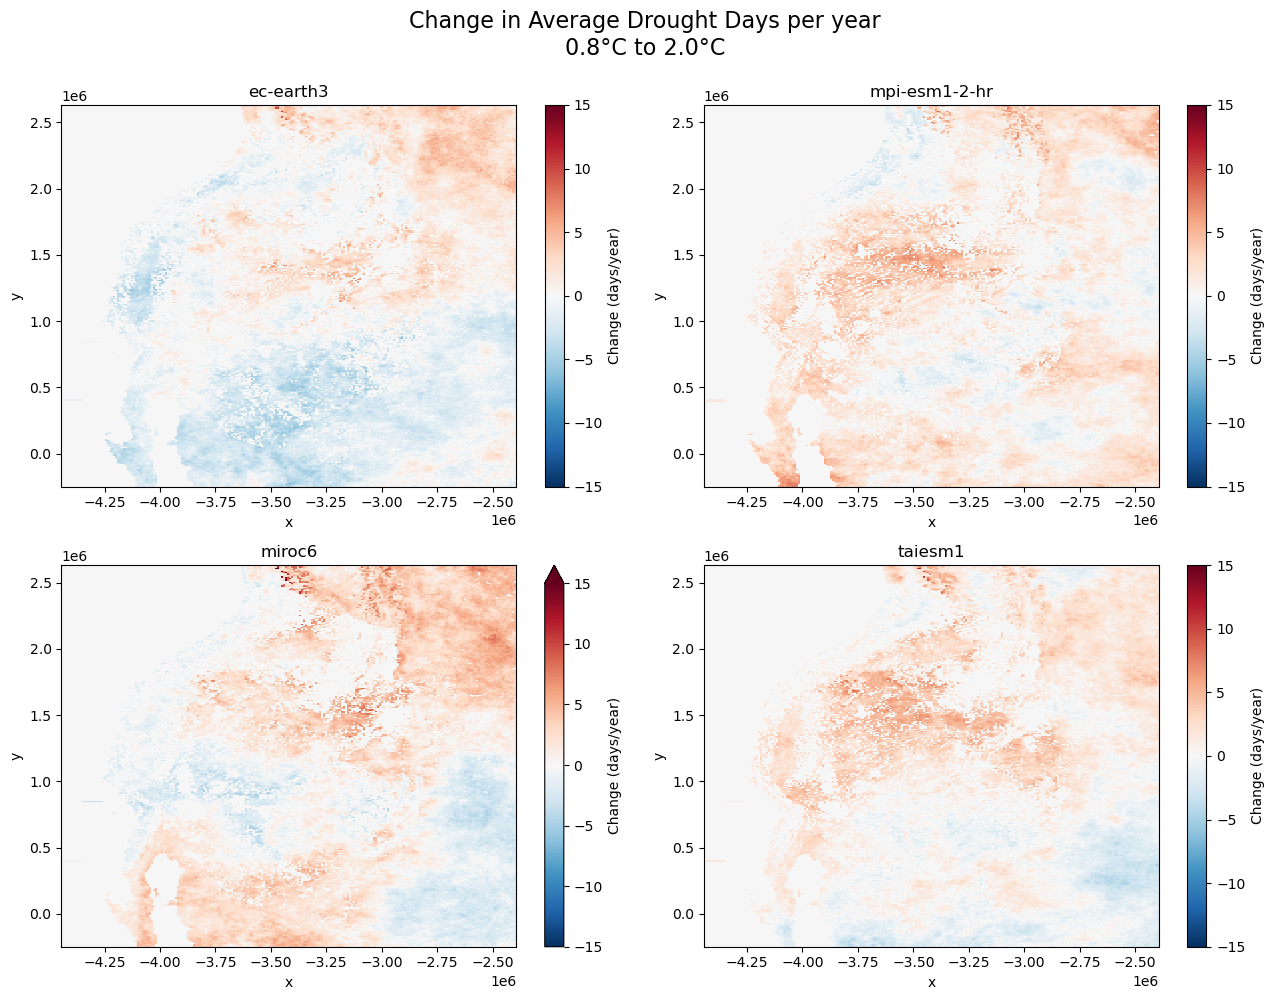

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(13,10))
axes = axes.flatten()

for i, sim in enumerate(simulations):
    avg_drought_days_per_year_delta.sel(simulation=sim).plot(
        ax=axes[i],
        cmap='RdBu_r',
        vmin=-15,
        vmax=15,
        cbar_kwargs={'label': 'Change (days/year)'}
    )
    axes[i].set_title(f"{sim}")
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

fig.suptitle(f"Change in Average Drought Days per year\n{reference_gwl}°C to {future_gwl}°C", 
             fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/prelim_change_in_avg_drought_days_per_year_{resource}_{module}_{domain}_{variable}_all_models_{future_gwl}C_minus_{reference_gwl}C.png", 
            dpi=300, bbox_inches='tight')
plt.show()

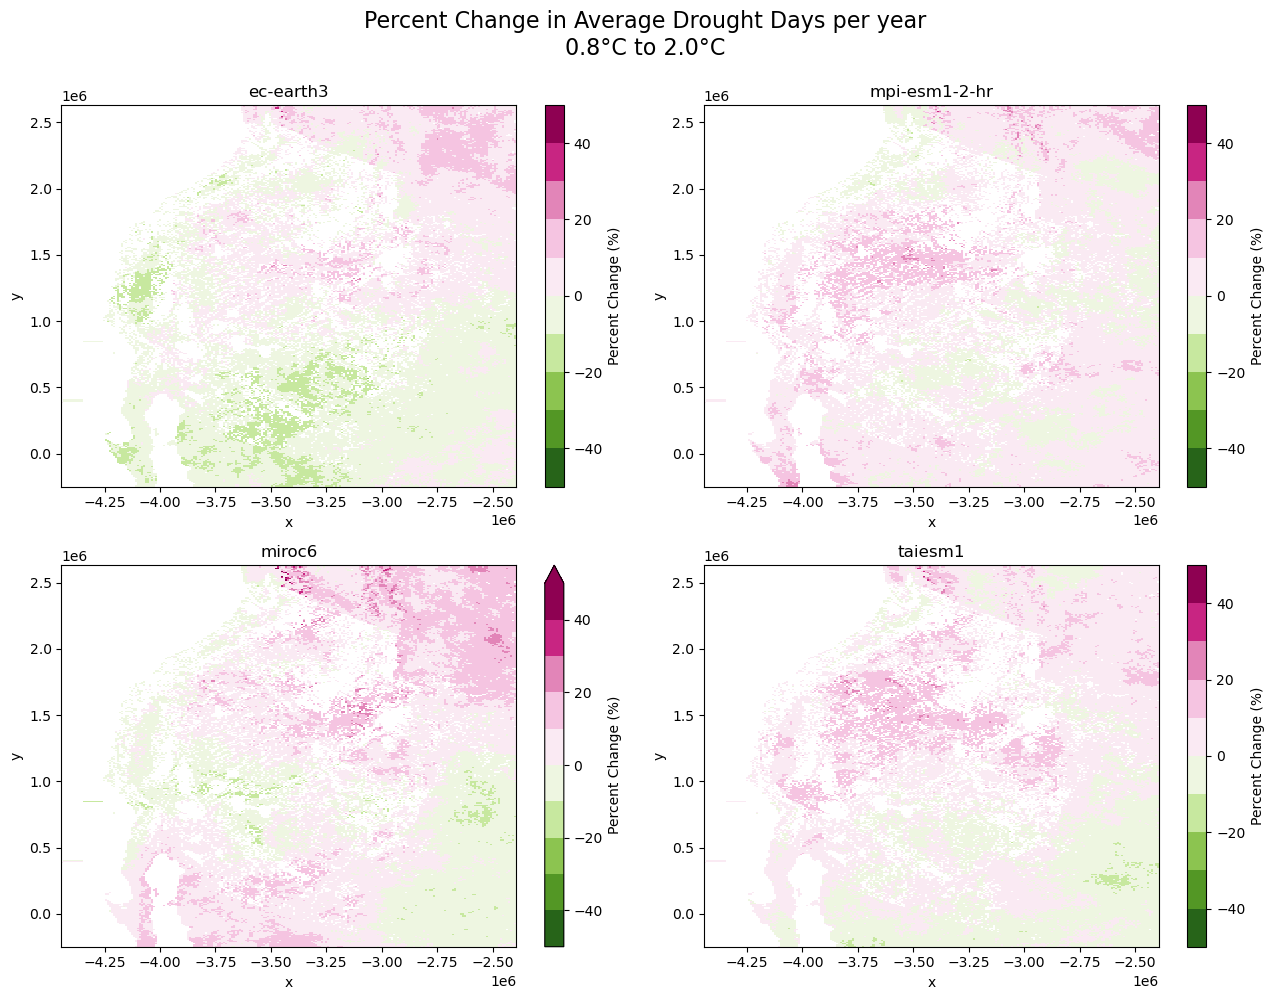

In [22]:
# make a segmented colorbar
segmented_cmap = plt.get_cmap('PiYG_r', 10)

fig, axes = plt.subplots(2, 2, figsize=(13,10))
axes = axes.flatten()

for i, sim in enumerate(simulations):
    avg_drougth_days_per_year_pct_change.sel(simulation=sim).plot(
        ax=axes[i],
        cmap=segmented_cmap,
        vmin=-50,
        vmax=50,
        cbar_kwargs={'label': 'Percent Change (%)'}
    )
    axes[i].set_title(f"{sim}")
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

fig.suptitle(f"Percent Change in Average Drought Days per year\n{reference_gwl}°C to {future_gwl}°C",
             fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/prelim_percent_change_in_avg_drought_days_per_year_{resource}_{module}_{domain}_{variable}_all_models_{future_gwl}C_minus_{reference_gwl}C.png",
            dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Calculate drought intensity metrics across all simulations
avg_drought_intensity = event_catalog_all.max_intensity.mean('event_id') * -1
avg_drought_intensity_delta = avg_drought_intensity.sel(gwl=future_gwl) - avg_drought_intensity.sel(gwl=reference_gwl)
percent_change_avg_drought_intensity = (avg_drought_intensity.sel(gwl=future_gwl) - avg_drought_intensity.sel(gwl=reference_gwl)) / avg_drought_intensity.sel(gwl=reference_gwl) * 100

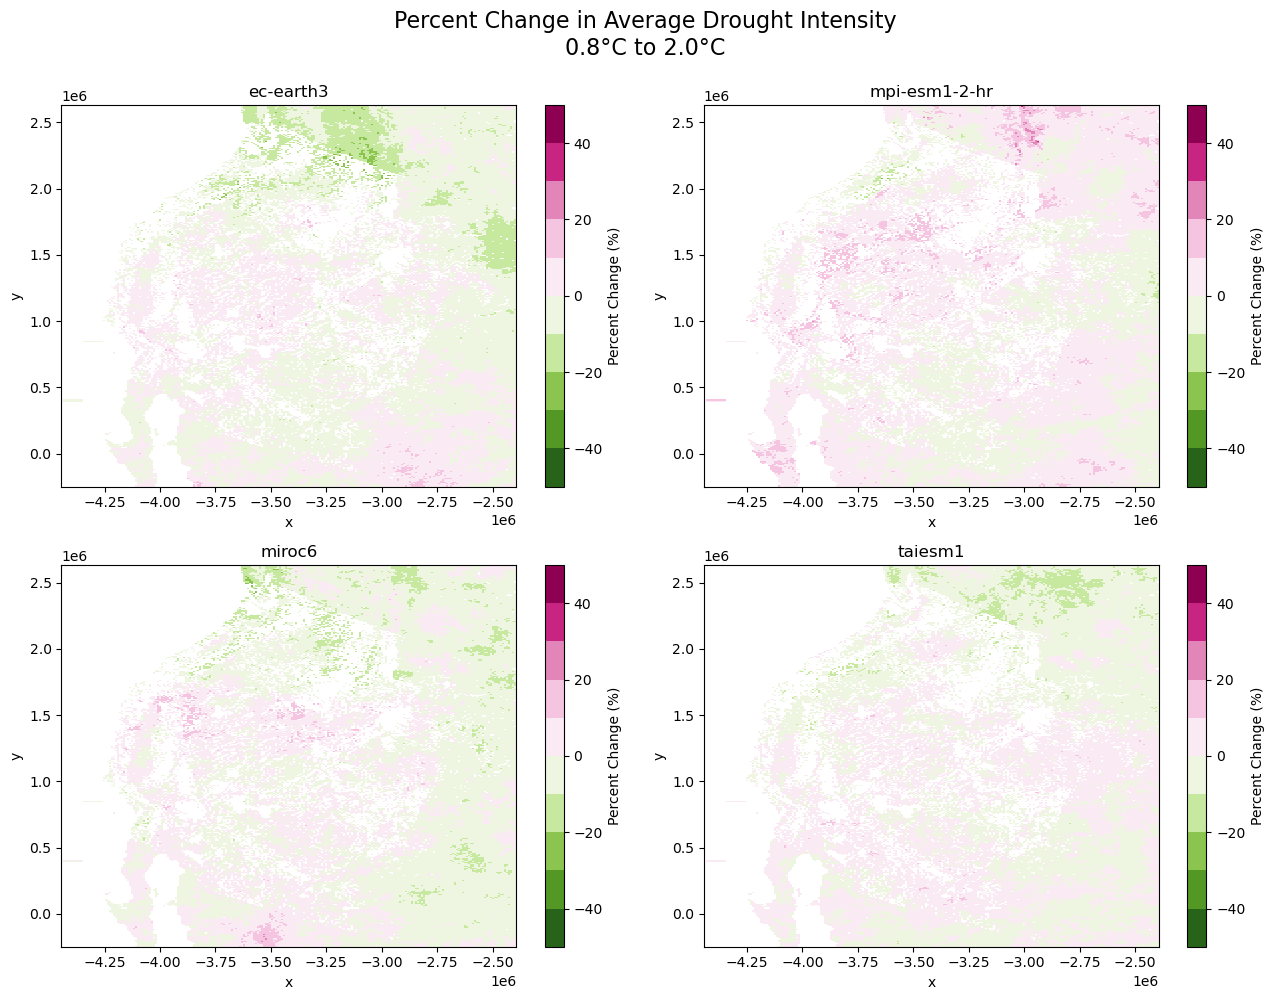

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(13,10))
axes = axes.flatten()
segmented_cmap = plt.get_cmap('PiYG_r', 10)

for i, sim in enumerate(simulations):
    percent_change_avg_drought_intensity.sel(simulation=sim).plot(
        ax=axes[i],
        cmap=segmented_cmap,
        vmin=-50,
        vmax=50,
        cbar_kwargs={'label': 'Percent Change (%)'}
    )
    axes[i].set_title(f"{sim}")
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

fig.suptitle(f"Percent Change in Average Drought Intensity\n{reference_gwl}°C to {future_gwl}°C",
             fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/prelim_percent_change_in_avg_drought_intensity_{resource}_{module}_{domain}_{variable}_all_models_{future_gwl}C_minus_{reference_gwl}C.png",
            dpi=300, bbox_inches='tight')
plt.show()


In [26]:
# Calculate longest drought metrics across all simulations
longest_drought = event_catalog_all.drought_duration.max('event_id')
longest_drought_delta = longest_drought.sel(gwl=future_gwl) - longest_drought.sel(gwl=reference_gwl)
percent_change_longest_drought = (longest_drought.sel(gwl=future_gwl) - longest_drought.sel(gwl=reference_gwl)) / longest_drought.sel(gwl=reference_gwl) * 100

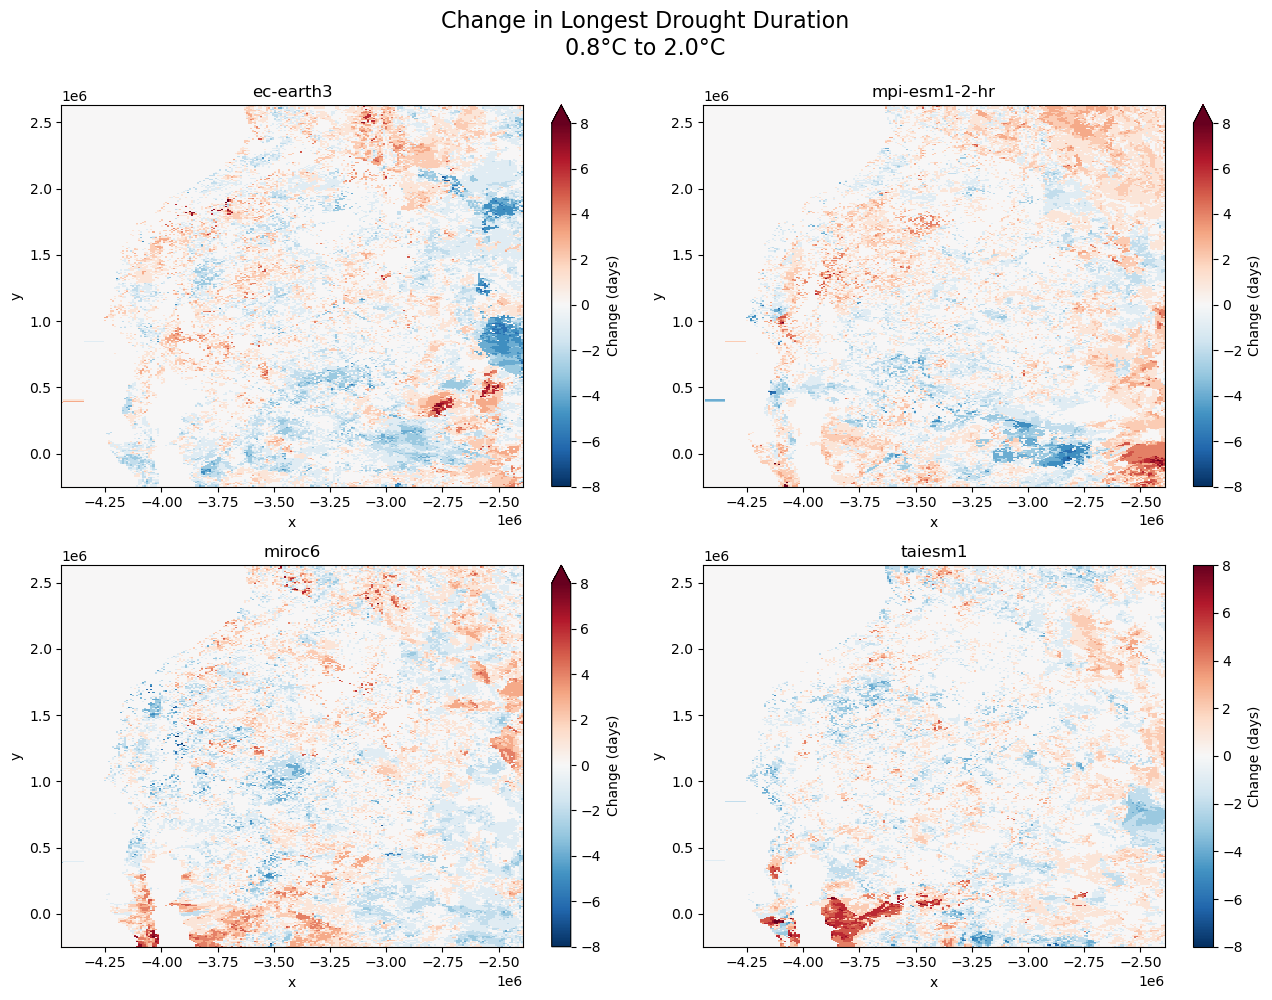

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(13,10))
axes = axes.flatten()

for i, sim in enumerate(simulations):
    longest_drought_delta.sel(simulation=sim).plot(
        ax=axes[i],
        cmap='RdBu_r',
        vmin=-8,
        vmax=8,
        cbar_kwargs={'label': 'Change (days)'}
    )
    axes[i].set_title(f"{sim}")
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')

fig.suptitle(f"Change in Longest Drought Duration\n{reference_gwl}°C to {future_gwl}°C",
             fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig(f"figures/prelim_change_in_longest_drought_{resource}_{module}_{domain}_{variable}_all_models_{future_gwl}C_minus_{reference_gwl}C.png",
            dpi=300, bbox_inches='tight')
plt.show()